# Vehicle detection and tracking



In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
import pickle

/Users/drisssqualli/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## HOG features extraction

Here we define the functions used to extract HOG features.

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

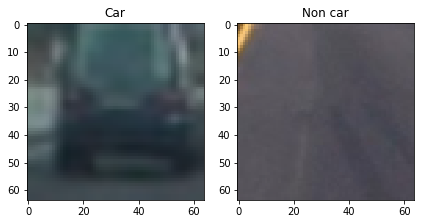

In [53]:
# Read in cars and notcars
cars = glob.glob('dataset/car/*/*.png')
notcars = glob.glob('dataset/notcar/*/*.png')

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

fig = plt.figure()
plt.subplot(121)
plt.imshow(mpimg.imread(cars[16]))
plt.title('Car')
plt.subplot(122)
plt.imshow(mpimg.imread(notcars[12]))
plt.title('Non car')
fig.tight_layout()
plt.savefig('output_images/car.png')
plt.show()

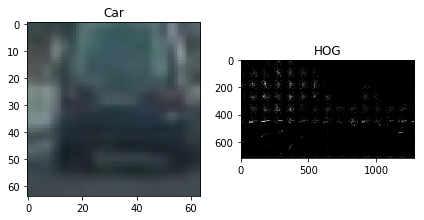

In [63]:
input_im = mpimg.imread(cars[16])
input_im = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
feat, img = get_hog_features(input_im[:,:,1],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
fig = plt.figure()
plt.subplot(121)
plt.imshow(mpimg.imread(cars[16]))
plt.title('Car')
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.title('HOG')
fig.tight_layout()
plt.savefig('output_images/HOG.png')
plt.show()

## Train the classifier

In [5]:


t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

173.15 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
1048.21 Seconds to train SVC...
Test Accuracy of SVC =  0.989


In [ ]:
# Save the model
with open('svc.pickle', 'wb') as file:
    pickle.dump(svc, file)
    pickle.dump(X_scaler, file)
    pickle.dump(orient, file)
    pickle.dump(pix_per_cell, file)
    pickle.dump(cell_per_block, file)
    pickle.dump(spatial_size, file)
    pickle.dump(hist_bins, file)
print('Model saved.')

## Search image for cars

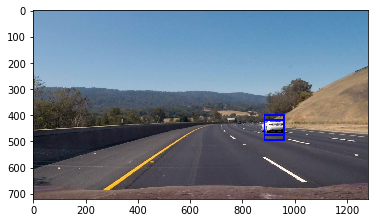

In [29]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,500:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+500, ytop_draw+ystart),(xbox_left+500+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left+500, ytop_draw+ystart),(xbox_left+500+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,box_list
    
# Test the find_cars function
ystart = 380
ystop = 540
scale = 1.2
image = mpimg.imread('test_images/test3.jpg')

out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
plt.show()

## Reduce false positives

In [27]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def get_boxes(labels):
    boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    # Return the image
    return boxes    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Test the heatmap

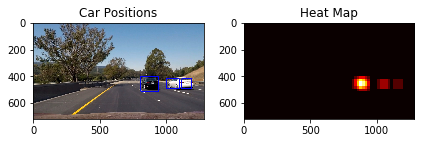

In [47]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test6.jpg')
out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list) 
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

### Tracking class

In [35]:
from collections import deque
# Define a class to receive the characteristics of each box detection
class Detection():
    def __init__(self, heat):
        self.current_boxes = []  
        # x values of the last n fits of the line
        self.recent_boxes = deque(maxlen=10)
        self.heatmap = heat
    def update_heatmap(self, heatmap):
        new_frame_factor = 0.3
        self.heatmap = new_frame_factor * heatmap + (1-new_frame_factor) * self.heatmap
    def set_current_boxes(self, boxes):
        self.current_boxes = boxes
        self.recent_boxes.append(boxes)
    def consistent_boxes(self):
        margin=40
        final_boxes = []
        for box in self.current_boxes:
            vote=0
            centroid = ((box[0][0]+box[1][0])/2,((box[0][1]+box[1][1])/2))
            #loop through boxes of previous frames
            for myboxes in self.recent_boxes:
                for mybox in myboxes:
                    mybox_centroid = ((mybox[0][0]+mybox[1][0])/2,((mybox[0][1]+mybox[1][1])/2))
                    if (abs(float(centroid[0]-mybox_centroid[0]))<margin and abs(float(centroid[1]-mybox_centroid[1]))<margin):
                        vote+=1
            if (vote>4):
                final_boxes.append(box)
        return final_boxes

## Pipeline

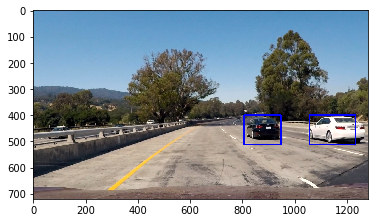

In [45]:
image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
my_detection = Detection(heat)

def pipeline(image):
    box_list=[]
    final_image = np.copy(image)
    
    # Search window for far vehicles
    ystart = 380
    ystop = 540
    scale = 1.2
    out_img, box_list1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Seach window for vehicles at intermediary distance
    ystart = 400
    ystop = 600
    scale = 1.4
    out_img, box_list2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    # Search window for close vehicles
    ystart = 400
    ystop = 650
    scale = 1.7
    out_img, box_list3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    box_list = box_list1 + box_list2 + box_list3
    
    if len(box_list)>0:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,4)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        #my_detection.update_heatmap(heatmap) 
        #labels = label(my_detection.heatmap)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        my_detection.set_current_boxes(get_boxes(labels))
        #final_image = draw_labeled_bboxes(np.copy(image), labels)
        final_image = draw_boxes(np.copy(image), my_detection.consistent_boxes())
    #plt.imsave('debug/image'+str(frame)+'.jpg',image)
    #plt.imsave('debug/pipeline'+str(frame)+'.jpg',final_image)
    return final_image

outpu = pipeline(image)
plt.imshow(outpu)
plt.show()

# Test the pipeline

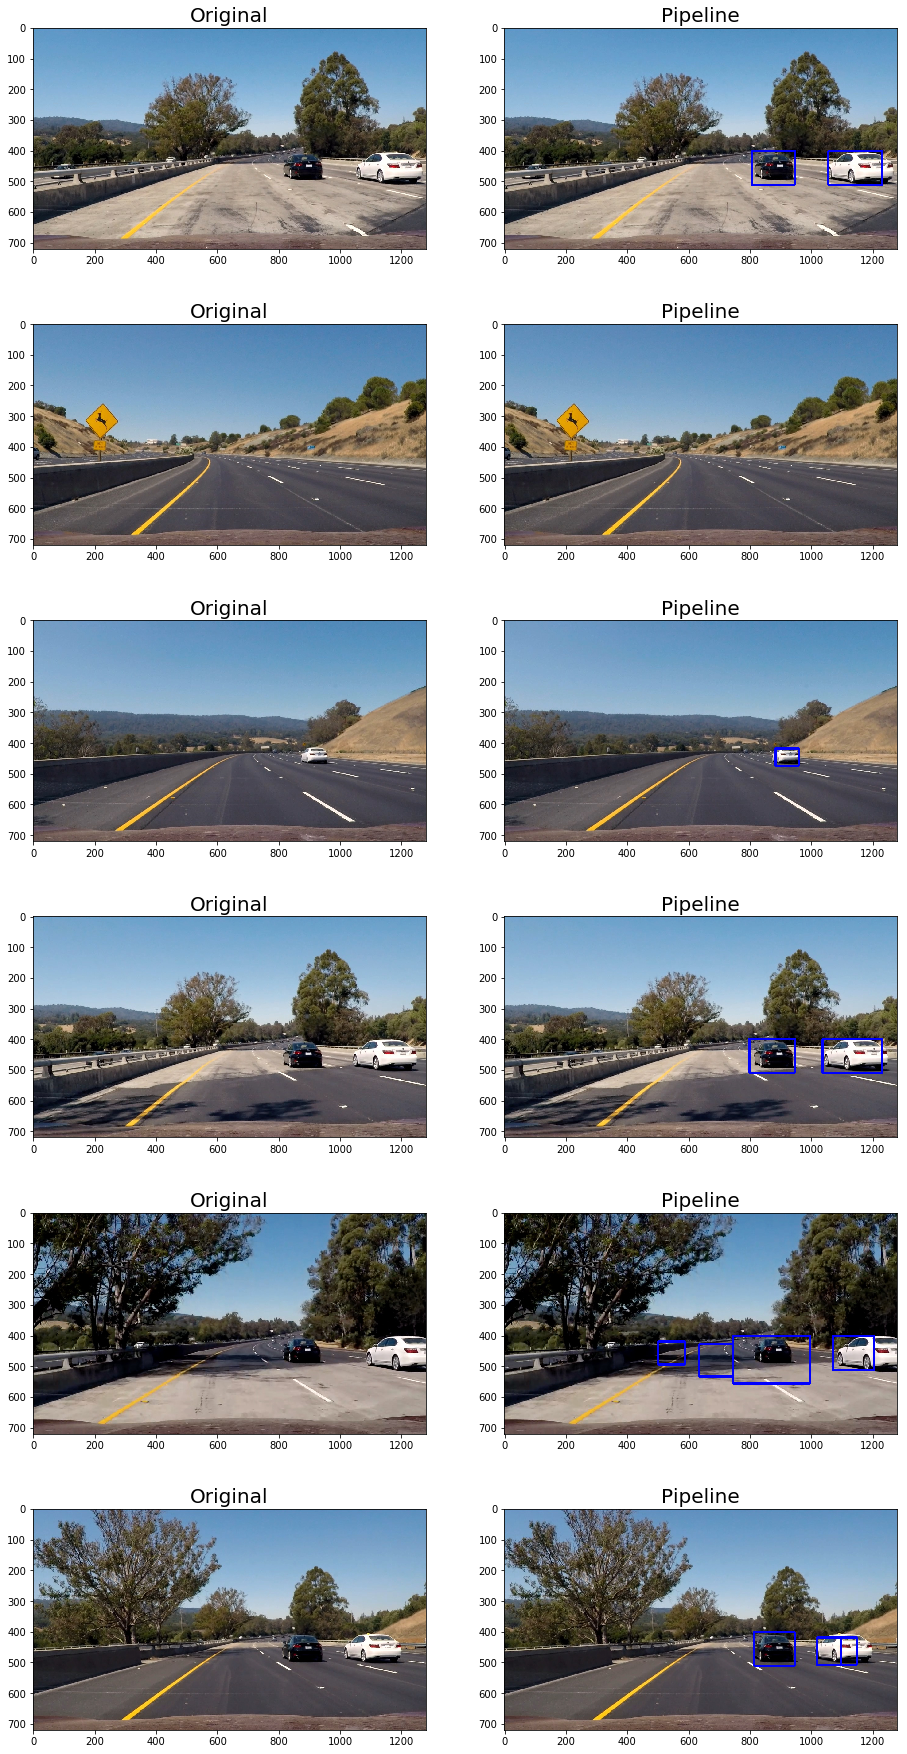

In [46]:
image1 = mpimg.imread('test_images/test1.jpg')
image2 = mpimg.imread('test_images/test2.jpg')
image3 = mpimg.imread('test_images/test3.jpg')
image4 = mpimg.imread('test_images/test4.jpg')
image5 = mpimg.imread('test_images/test5.jpg')
image6 = mpimg.imread('test_images/test6.jpg')

f, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10), (ax11, ax12) ) = plt.subplots(6, 2, figsize=(12,24 ))
ax1.imshow(image1)
ax1.set_title('Original', fontsize=20)
ax2.imshow(pipeline(image1))
ax2.set_title('Pipeline', fontsize=20)
ax3.imshow(image2)
ax3.set_title('Original', fontsize=20)
ax4.imshow(pipeline(image2))
ax4.set_title('Pipeline', fontsize=20)
ax5.imshow(image3)
ax5.set_title('Original', fontsize=20)
ax6.imshow(pipeline(image3))
ax6.set_title('Pipeline', fontsize=20)
frame_count=0
ax7.imshow(image4)
ax7.set_title('Original', fontsize=20)
ax8.imshow(pipeline(image4))
ax8.set_title('Pipeline', fontsize=20)
ax9.imshow(image5)
ax9.set_title('Original', fontsize=20)
ax10.imshow(pipeline(image5))
ax10.set_title('Pipeline', fontsize=20)
ax11.imshow(image6)
ax11.set_title('Original', fontsize=20)
ax12.imshow(pipeline(image6))
ax12.set_title('Pipeline', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1., bottom=0.)
plt.savefig('output_images/pipeline_test.png')

plt.show()

## Video editing

In [ ]:
image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
my_detection = Detection(heat)
frame_count=0
from moviepy.editor import VideoFileClip
output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(lambda img: pipeline(img))
%time clip.write_videofile(output, audio=False)